# kNN


## Table of Contents

**kNN with scikit-learn**
1. [kNN based plain vanilla ML steps](#knn-vanilla)
2. [Cross validation for k using scikit learn API](#cv)
3. [GridSearch & RandomSearch for multiple hyperparameter tuning](#gridsearch)
4. [Beyond GridSearch - Lack of stability even after GridSearchCV (Optional)](#beyond-gridsearch)
5. [Cross validation from scratch](cv-from-scratch)

**Assignments**
1. [train test split from scratch](#train-test-scratch)
2. [kNN from scratch](#knn-scratch)
3. [GridSearch from scratch](#gridsearch-scratch)
4. [Integrate your custom code](#integrate)

In [1]:
import numpy as np
import pandas as pd

import sklearn as sk

In [66]:
print(f"numpy version = {np.__version__}")  #Check the numpy version for sanity check
print(f"sklearn version = {sk.__version__}")

numpy version = 1.19.5
sklearn version = 0.22.1


<a id='knn-vanilla'></a>
<hr/>

## kNN with scikit-learn

### 1. kNN based plain vanilla ML steps

##### 1.1 Acquire and load data

In [13]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris

# save "bunch" object containing iris dataset and its attributes
iris = load_iris()

#store feature matrix in dataframe
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# store response vector in "y"
y = iris.target

In [14]:
# print the shapes of X and y
print(df.shape)
print(y.shape)

(150, 4)
(150,)


##### 1.2 3 step ML process

1. Model Selection
2. Model Training (plus Tuning)
3. Model Evaluation

In [15]:
# Start by train/test split data with random_state 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)

In [16]:
print(f"type(X_train)={type(X_train)}") # when dataframe is passed, the split is also dataframe
print(f"type(y_train)={type(y_train)}")

type(X_train)=<class 'pandas.core.frame.DataFrame'>
type(y_train)=<class 'numpy.ndarray'>


In [17]:
# 1. Model Selection
# import the algorithm instantiate the algorithm class
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=1)

In [18]:
# 2. Model Training (& Tuning)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [19]:
# 3. Model Evaluation (Prediction)

from sklearn import metrics
y_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy with k = 1 {accuracy}")

Accuracy with k = 1 0.9473684210526315


<a id='cv'></a>
<hr/>

### 2. Cross validation for k using scikit learn API

K-Fold CV diagram 

![CV](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211929&authkey=%21AOCi-KlSCxdsSqo&width=631&height=279)


**Different types of Validation**

1. Holdout: In some sense, Train-Test Split is also one extreme of K-Fold Cross validation. Here we can assume the entire X is split into 2 parts (k=2). The train split is used for model training; test part is used for model testing. Test split is called Holdout. And this validation method is also referred to as Hold-out Cross Validation

2. K-Fold CV: The K-Fold Cross Validation we have adopted is a practical combination of holdout and the pure form of K-Fold Cross validation. We first do the split for hold out and then execute K-Fold CV as if it is complete dataset. If data is scarce, then we could first choose 90:10 train-test split instead of 80:20, followed a higher K for K-Fold CV.

3. Stratified CV: When there is some class imbalance in the dataset, we would like to get each class a representative share in model training and validation, which otherwise may not be possible with random shuffle and sampling. Rest of this is same as K-Fold CV

4. Leave-One-Out CV (LOOCV): is another extreme from holdout, where the total number of folds = number of observations (in X_train as applied to our case). If X_train split contained n rows, the model is trained on n-1 and validated on 1. This is computationally very expensive. But this should be used if the dataset is quite small.

5. Repeated K-Fold CV: K-Fold CV repeated and/or stratified
6. Nested CV: This is nothing but GridSearchCV and RandomSearch CV

Question: What is the computational cost of each type of CV? 


##### 2.1 K-Fold CV

1. K-Fold CV divides dataset into k non-overlapping folds. 
2. Each of the k folds gets an opportunity to be used as hold-out test set, when all other folds collectively are used as training dataset. 
3. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported

In [20]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=2)
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross Validation scores = {scores}")
print(f"type={type(scores)}")
print(f"Average CV accuracy for k=2 is {np.mean(scores)}")

Cross Validation scores = [0.95652174 0.91304348 0.95454545 1.         1.        ]
type=<class 'numpy.ndarray'>
Average CV accuracy for k=2 is 0.9648221343873518


In [21]:
# search for an optimal value of K for KNN
k_range = list(range(1, 20))
k_avg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_avg_scores.append(scores.mean())
print(np.round(np.array(k_avg_scores), decimals=3))

[0.965 0.965 0.974 0.965 0.974 0.983 0.982 0.973 0.982 0.982 0.991 0.982
 0.974 0.964 0.974 0.964 0.964 0.964 0.964]


Text(0, 0.5, 'CV Accuracy')

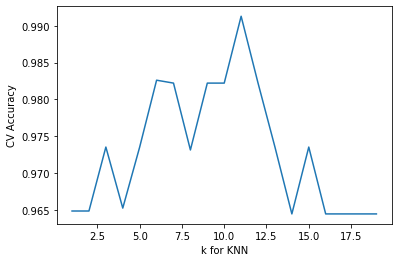

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_avg_scores)
plt.xlabel('k for KNN')
plt.ylabel('CV Accuracy')

In [23]:
# choose best k
np.argmax(np.array(k_avg_scores))+1 #why the +1?

11

In [24]:
# Whats different from previous code cell? 
# KFold object is explicitly provided for cv instead of mere number.
# This allows fine grained control over the KFold

from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)

k_range = list(range(1, 25))
k_avg_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    kfold = KFold(n_splits=5, shuffle=False) #this is new in this code cell
    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy') 
    k_avg_scores.append(scores.mean())
print(np.round(np.array(k_avg_scores), decimals=3))

[0.965 0.956 0.974 0.956 0.974 0.964 0.974 0.964 0.973 0.982 0.964 0.982
 0.974 0.964 0.974 0.955 0.955 0.955 0.955 0.947 0.947 0.947 0.956 0.956]


##### 2.2 Leave One Out Cross Validation (LOOCV)

1. This is equivalent to saying n-fold CV. where n is the number of records. Each record is a fold
2. n-1 folds are combined to form the training portion. 1 record is used for validation
3. Very effective for checking hyperparameters, especially when data is very less, but computationally very expensive 

In [25]:
from sklearn.model_selection import LeaveOneOut

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)

k_range = list(range(1, 25))
k_avg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    loocv = LeaveOneOut()
    scores = cross_val_score(knn, X_train, y_train, cv=loocv, scoring='accuracy') #Leave One out CV object provided for cv
    k_avg_scores.append(scores.mean())

print(np.round(np.array(k_avg_scores), decimals=3))

[0.964 0.955 0.973 0.964 0.973 0.973 0.982 0.973 0.973 0.964 0.973 0.973
 0.982 0.982 0.964 0.955 0.955 0.955 0.964 0.938 0.946 0.938 0.946 0.946]


In [26]:
best_k = np.argmax(np.array(k_avg_scores))+1
print(f"Best value for k is {best_k}")

Best value for k is 7


Text(0, 0.5, 'CV Accuracy')

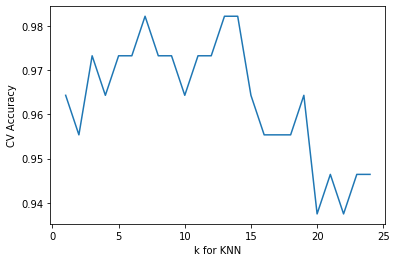

In [27]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_avg_scores)
plt.xlabel('k for KNN')
plt.ylabel('CV Accuracy')

##### 2.3 Stratified K-Fold CV

1. Best option for CV on imbalanced dataset
2. For a generic parametric model like Logistic Regression etc., the impact of higher class imbalance on hyperparameter tuning with Stratified K-Fold is that it will get a representative train and test dataset and discover higher & better L2 Regularization lambda
3. For kNN, however, the model reacts by finding a lower k to increase its accuracy. This is undesirable side effect of kNN on imbalanced dataset. We attempt to fix this by setting the lower k range to be at least 5
4. kNN is a very bad choice for imbalanced dataset
5. Also accuracy is not the best measure for model performance in imbalanced dataset
6. In general the model trained with stratified split and stratified kfold is robust

In [28]:
# Stratified CV example with a synthetic dataset

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

# generate data
X_imb, y_imb = make_classification(n_samples=1000, n_classes=2, weights=[0.95, 0.05], flip_y=0, random_state=1)

X_imb_train, X_imb_test, y_imb_train, y_imb_test = \
    train_test_split(X_imb, y_imb, test_size = 0.2, stratify=y_imb, shuffle = True, random_state = 0)

X_imb_train[0:5,0:2], y_imb_train[0:5]

(array([[ 0.56177533, -1.77472878],
        [ 0.39969041,  0.41708222],
        [ 0.51992732, -0.53357566],
        [ 0.63123936, -1.12899169],
        [ 2.22382082, -1.335088  ]]),
 array([0, 0, 0, 0, 0]))

In [29]:
# summarize dataset
classes = np.unique(y_imb)
total = len(y_imb)
for c in classes:
 n_examples = len(y_imb[y_imb==c])
 percent = n_examples / total * 100
 print('> Class=%d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class=0 : 950/1000 (95.0%)
> Class=1 : 50/1000 (5.0%)


In [30]:
k_lower_limit = 3
k_range = list(range(k_lower_limit, 25))
k_avg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(knn, X_imb_train, y_imb_train, cv=kfold, scoring='accuracy')
    k_avg_scores.append(scores.mean())

print(np.round(np.array(k_avg_scores), decimals=3))

best_k = np.argmax(np.array(k_avg_scores)) + k_lower_limit
print(f"Best value for k is {best_k}")

# Fit the model again with best k obtained in cross validation
knn1 = KNeighborsClassifier(n_neighbors=best_k) 
knn1.fit(X_imb_train, y_imb_train)
y_imb_pred = knn1.predict(X_imb_test)
accuracy = metrics.accuracy_score(y_imb_test, y_imb_pred)
print(f"Test accuracy with K-Fold and best k = {best_k} is {accuracy}")

[0.948 0.951 0.95  0.95  0.949 0.95  0.95  0.95  0.95  0.95  0.95  0.95
 0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95 ]
Best value for k is 4
Test accuracy with K-Fold and best k = 4 is 0.95


In [31]:
k_lower_limit = 3
k_range = list(range(k_lower_limit, 25))
k_avg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(knn, X_imb_train, y_imb_train, cv=skfold, scoring='accuracy')
    k_avg_scores.append(scores.mean())

print(np.round(np.array(k_avg_scores), decimals=3))

best_k = np.argmax(np.array(k_avg_scores)) + k_lower_limit
print(f"Best value for k is {best_k}")

# Fit the model again with best k obtained in cross validation
knn2 = KNeighborsClassifier(n_neighbors=best_k) 
knn2.fit(X_imb_train, y_imb_train)
y_imb_pred = knn2.predict(X_imb_test)
accuracy = metrics.accuracy_score(y_imb_test, y_imb_pred)
print(f"Accuracy with Stratified K-Fold and best k = {best_k} is {accuracy}")

[0.956 0.952 0.955 0.95  0.952 0.95  0.95  0.95  0.95  0.95  0.95  0.95
 0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95 ]
Best value for k is 3
Accuracy with Stratified K-Fold and best k = 3 is 0.95


##### 2.4 Repeated K-Fold CV

1. K-Fold runs on different train and val folds in each iteration. This provides a noisy estimate (by design)
2. One way to reduce the noise is increase k in K-Fold. This reduces the bias in estimated model performance, but increases variance
3. One solution is to repeat each fold of the K-Fold a certain number of times and report the mean metrics of the repeats for that given KFold. This fixes the variance issue  

In [32]:
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)

In [33]:
knn1 = KNeighborsClassifier(n_neighbors=3)
kfold1 = KFold(n_splits=5, shuffle=True, random_state=42)
scores1 = cross_val_score(knn1, X_train, y_train, cv=kfold1, scoring='accuracy')

knn2 = KNeighborsClassifier(n_neighbors=3)
kfold2 = KFold(n_splits=10, shuffle=True, random_state=42)
scores2 = cross_val_score(knn2, X_train, y_train, cv=kfold2, scoring='accuracy')

print(f"Variance of scores in 5-Fold = {np.var(scores1)}")
print(f"Variance of scores in 10-Fold = {np.var(scores2)}")
scores1

Variance of scores in 5-Fold = 0.0012242028464747152
Variance of scores in 10-Fold = 0.0015518824609733713


array([0.91304348, 1.        , 1.        , 1.        , 0.95454545])

In [34]:
from sklearn.model_selection import RepeatedKFold

knn = KNeighborsClassifier(n_neighbors=3)
rkfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
scores3 = cross_val_score(knn, X_train, y_train, cv=rkfold, scoring='accuracy')

print(f"Variance of scores in Repeated 5-Fold = {np.var(scores3)}")
scores3

Variance of scores in Repeated 5-Fold = 0.0012098298676748588


array([0.91304348, 1.        , 1.        , 1.        , 0.95454545,
       0.95652174, 1.        , 0.90909091, 1.        , 0.95454545])

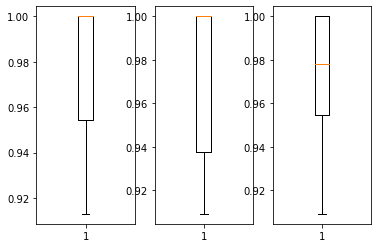

In [35]:
plt.subplot(1,3,1)
plt.boxplot(scores1)
plt.subplot(1,3,2)
plt.boxplot(scores2)
plt.subplot(1,3,3)
plt.boxplot(scores3)
plt.show()

<a id='gridsearch'></a>
<hr/>

### 3 GridSearch & RandomSearch for multiple hyperparameter tuning

##### 3.1 Grid Search
1. The code below uses LOOCV for CV. We could even use K-Fold CV instead

In [36]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25), "weights": ["uniform", "distance"]}

loocv = LeaveOneOut()

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=loocv) #can also specify something like cv=5 for a plain KFold 
#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [38]:
print(type(knn_gscv.cv_results_))
print(knn_gscv.cv_results_.keys())
print(np.array(knn_gscv.cv_results_["mean_test_score"]))
print(np.array(knn_gscv.cv_results_["mean_test_score"]).shape)
print(np.argmax(np.array(knn_gscv.cv_results_["mean_test_score"])))

<class 'dict'>
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'split12_test_score', 'split13_test_score', 'split14_test_score', 'split15_test_score', 'split16_test_score', 'split17_test_score', 'split18_test_score', 'split19_test_score', 'split20_test_score', 'split21_test_score', 'split22_test_score', 'split23_test_score', 'split24_test_score', 'split25_test_score', 'split26_test_score', 'split27_test_score', 'split28_test_score', 'split29_test_score', 'split30_test_score', 'split31_test_score', 'split32_test_score', 'split33_test_score', 'split34_test_score', 'split35_test_score', 'split36_test_score', 'split37_test_score', 'split38_test_score', 'split39

##### 3.2 Random Search

In [39]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25), "weights": ["uniform", "distance"]}

loocv = LeaveOneOut()

#use gridsearch to test all values for n_neighbors
knn_rscv = RandomizedSearchCV(knn, param_grid, cv=loocv) #can also specify something like cv=5 for a plain KFold 
#fit model to data
knn_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=LeaveOneOut(), error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [40]:
#check top performing n_neighbors value
knn_rscv.best_params_

{'weights': 'uniform', 'n_neighbors': 19}

In [41]:
print(type(knn_rscv.cv_results_))
print(knn_rscv.cv_results_.keys())
print(np.array(knn_rscv.cv_results_["mean_test_score"]))
print(np.array(knn_rscv.cv_results_["mean_test_score"]).shape)
print(np.argmax(np.array(knn_rscv.cv_results_["mean_test_score"])))

<class 'dict'>
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_weights', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'split12_test_score', 'split13_test_score', 'split14_test_score', 'split15_test_score', 'split16_test_score', 'split17_test_score', 'split18_test_score', 'split19_test_score', 'split20_test_score', 'split21_test_score', 'split22_test_score', 'split23_test_score', 'split24_test_score', 'split25_test_score', 'split26_test_score', 'split27_test_score', 'split28_test_score', 'split29_test_score', 'split30_test_score', 'split31_test_score', 'split32_test_score', 'split33_test_score', 'split34_test_score', 'split35_test_score', 'split36_test_score', 'split37_test_score', 'split38_test_score', 'split39

<a id='beyond-gridsearch'></a>
<hr/>

### 4 Beyond GridSearch - Lack of stability even after GridSearchCV (Optional)

1. We run the KFold CV with two different data split and demonstrate that the k obtained even after Cross validation is not sufficient.
2. Then we switch to LOOCV with different distance metric and repeat the process along with different train test split. This would have been generally achieved by a GridSearchCV in general.
3. With the above two experiments we can conclude that even LOOCV based Grid Search is not going to be robust in selecting a good k value.
4. Then we adopt a totally different approach of different train test split and running LOOCV and take a set intesection on the last 5 best scores. These methods from less charted path are generally used in Kaggle competitions  

##### 4.1 KFold CV with one variety of train test split

In [42]:
# We start by making a function out of KFold CV for reuse
def knn_kfold_cv(X_train, y_train, mink=1, maxk=25):
    k_range = list(range(mink, maxk))
    k_avg_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        k_avg_scores.append(scores.mean())

    return k_avg_scores

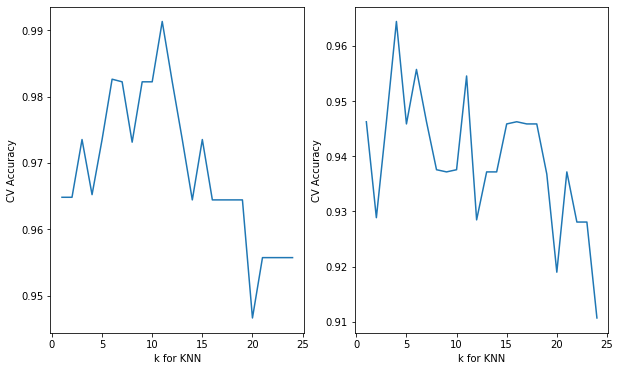

In [43]:
k_range = list(range(1, 25))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 6))

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)
k_avg_scores1 = knn_kfold_cv(X_train, y_train, mink=1, maxk=25)

axes[0].plot(k_range, k_avg_scores1) #plt.plot(k_range, k_avg_scores)
axes[0].set_xlabel('k for KNN') #plt.xlabel('k for KNN')
axes[0].set_ylabel('CV Accuracy') #plt.ylabel('CV Accuracy')


X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)
k_avg_scores2 = knn_kfold_cv(X_train, y_train, mink=1, maxk=25)

axes[1].plot(k_range, k_avg_scores2)
axes[1].set_xlabel('k for KNN')
axes[1].set_ylabel('CV Accuracy')

plt.show()

##### 4.2 LOOCV with different train test split

In [44]:
# For this purpose, we start by making a function out of CV
def knn_loocv(X_train, y_train, mink=1, maxk=25):
    k_range = list(range(mink, maxk))
    k_avg_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
        loocv = LeaveOneOut()
        scores = cross_val_score(knn, X_train, y_train, cv=loocv, scoring='accuracy')
        k_avg_scores.append(scores.mean())

    return k_avg_scores

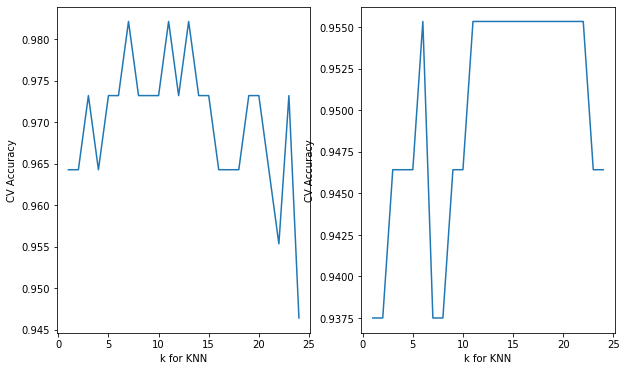

In [45]:
k_range = list(range(1, 25))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 6))

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)
k_avg_scores1 = knn_loocv(X_train, y_train, mink=1, maxk=25)

axes[0].plot(k_range, k_avg_scores1) #plt.plot(k_range, k_avg_scores)
axes[0].set_xlabel('k for KNN') #plt.xlabel('k for KNN')
axes[0].set_ylabel('CV Accuracy') #plt.ylabel('CV Accuracy')


X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)
k_avg_scores2 = knn_loocv(X_train, y_train, mink=1, maxk=25)

axes[1].plot(k_range, k_avg_scores2)
axes[1].set_xlabel('k for KNN')
axes[1].set_ylabel('CV Accuracy')

plt.show()

1. Intersection over the top5 score of both cross validation over different splits 
2. This is follwoeds by set intersection over the top 5 scores gives best and robust solution

This comes atr a big cost. Lot more computing

In [46]:
max5_set1 = set(np.argsort(np.array(k_avg_scores1))[-5:])
max5_set2 = set(np.argsort(np.array(k_avg_scores2))[-5:])

max5_set1.intersection(max5_set2)

{11}

<a id='cv-from-scratch'></a>
<hr/>

### 5. Cross validation from scratch (not exactly scratch scratch)

In [47]:
# Demonstrating data split in K-Fold Cross validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False)

#dummy data
data = range(25)

# print the contents of training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set indices', 'Validation set indices'))
iter_idx = 1
for train_idx, val_idx in kf.split(data):
    print('{:^9} {} {:^25}'.format(iter_idx, train_idx, str(val_idx)))
    iter_idx += 1

Iteration                     Training set indices                      Validation set indices
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


In [48]:
# Cross validation from scratch with k=2

k_knn = 2 #How many k to use in kNN

kfold_splits = 5 # how many splits in K-Fold CV

kf = KFold(n_splits=kfold_splits, shuffle=False) #create the KFold object

iter_idx = 0 # This looping cannot be obtained by enumerate. Hence manually defined

accuracy_arr = np.empty(kfold_splits) #To store the accuracy of each iter in CV

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4)

# kf.split returns indices on X_train 
for train_idx, val_idx in kf.split(X_train):

    # split the original X_train into train and val data for this iter 
    X_train_cv = X_train.iloc[train_idx]
    y_train_cv = y_train[train_idx]

    X_val_cv =  X_train.iloc[val_idx]
    y_val_cv = y_train[val_idx]

    knn = KNeighborsClassifier(n_neighbors=k_knn)
    knn.fit(X_train_cv, y_train_cv)
    y_pred_cv = knn.predict(X_val_cv)
    accuracy = metrics.accuracy_score(y_val_cv, y_pred_cv)
   
    print(f"Iteration {iter_idx} score: {accuracy}")

    #store the accuracy of this iter in arr to calc mean accuracy later
    accuracy_arr[iter_idx] = accuracy
    iter_idx += 1

print(f"Average CV accuracy for k={k_knn} is {np.mean(accuracy_arr)}")

Iteration 0 score: 0.9565217391304348
Iteration 1 score: 0.9130434782608695
Iteration 2 score: 0.9545454545454546
Iteration 3 score: 0.9545454545454546
Iteration 4 score: 1.0
Average CV accuracy for k=2 is 0.9557312252964426


<a id='train-test-scratch'></a>
<hr/>

## Assignments

### 1. train test split from scratch

Create a function my_train_test_split() that takes input X, y and fraction of train. And ouputs the list or tuple containing splits

In [49]:
#Clue 1: Splitting the data sequentially for a given fraction

data = np.array([[1, 2, 0], [3, 4, 1], [5, 6, 1], [7, 8, 0], [9, 10, 1], [11, 12, 0]])
print('data:')
print(data)

# Train part of the data
split = int(0.8*data.shape[0])
X_train = data[:split, :-1]
y_train = data[:split, -1]

print('\nX_train:')
print(X_train)
print('\ny_train:')
print(y_train)

# The test part of the data
X_test = data[split:, :-1]
y_test = data[split:, -1]

print('\ny_train:')
print(X_test)

print('\ny_test:')
print(y_test)

data:
[[ 1  2  0]
 [ 3  4  1]
 [ 5  6  1]
 [ 7  8  0]
 [ 9 10  1]
 [11 12  0]]

X_train:
[[1 2]
 [3 4]
 [5 6]
 [7 8]]

y_train:
[0 1 1 0]

y_train:
[[ 9 10]
 [11 12]]

y_test:
[1 0]


In [50]:
#Clue2: splitting data randomly
data = np.array([[1, 2, 0], [3, 4, 1], [5, 6, 1], [7, 8, 0]])
num_samples = data.shape[0]
ind = np.random.choice(num_samples, num_samples, replace = False)
print(ind)
print(type(ind))
split = int(0.8*num_samples)
print(split)
ind[:split]

[2 3 1 0]
<class 'numpy.ndarray'>
3


array([2, 3, 1])

In [51]:
## TODO: Your function definition goes here
import numpy as np

def my_train_test_split(X, y, train_fraction=0.8, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Determine the number of samples for training
    num_samples = len(X)
    num_train_samples = int(num_samples * train_fraction)

    # Create an array of indices and shuffle them
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Split the indices into training and testing sets
    train_indices = indices[:num_train_samples]
    test_indices = indices[num_train_samples:]

    # Use the indices to extract the train and test subsets of X and y
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]

    return train_X, test_X, train_y, test_y


In [52]:
## TODO: Your function invocation goes here
import numpy as np

# Sample data 
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = np.array([0, 1, 0, 1, 1])

# Specify the train fraction (e.g., 0.8 for an 80/20 split)
train_fraction = 0.8

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = my_train_test_split(X, y, train_fraction)

# Now, you have 'train_X', 'test_X', 'train_y', and 'test_y' for your training and testing data, respectively.


<a id='knn-scratch'></a>
<hr/>

### 2. kNN from scratch

In [67]:
# # KNN class that allows setting the number of neighbours and weight=uniform or distance
# class KNN:
#     def __init__(self, ......): #Fill this out
#         pass

#     def fit(X, y): # What is missing in function definition?
#         pass

#     def predict(X): # What is missing in function definition?
#         pass

In [68]:
import numpy as np
class KNNClassifier:
    def __init__(self, k=3, weights='uniform', p=2):
        self.k = k
        self.weights = weights
        self.p = p

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Calculate distances between x and all examples in the training set
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]

        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        if self.weights == 'uniform':
            # If weights are uniform, return the most common class label
            most_common = np.bincount(k_nearest_labels).argmax()
            return most_common
        elif self.weights == 'distance':
            # If weights are based on distance, return the class label with weighted votes
            class_votes = {}
            for label, distance in zip(k_nearest_labels, distances):
                if label in class_votes:
                    class_votes[label] += 1 / (distance + 1e-5)  # Adding a small value to avoid division by zero
                else:
                    class_votes[label] = 1 / (distance + 1e-5)
            return max(class_votes, key=class_votes.get)


In [74]:
k = 5
knn = KNNClassifier(k)
knn.fit(X_train, y_train)

In [75]:
y_pred = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 1.0


<a id='gridsearch-scratch'></a>
<hr/>

### 3. GridSearch from scratch

In [ ]:
# Clue: Look at itertools.product() functionality in python.
# It will allow you to create Cartesian products needed for multiple hyperparam tuning
# Use it in a loop to write your custom Grid Search

In [112]:
import itertools
import numpy as np

class GridSearch:
    def grid_search(params1,params2,x_train,y_train,x_cv,y_cv):
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }

        # Create a list of all possible combinations of hyperparameters
        param_combinations = list(itertools.product(*param_grid.values()))

        # Initialize variables 
        best_params = None
        best_accuracy = 0.0

        # Loop through each combination of hyperparameters
        for params in param_combinations:
            n_neighbors, weights, p = params
            
            # Initialize k-NN classifier with the current hyperparameters
            knn = KNNClassifier(k=n_neighbors, weights=weights, p=p)
            
            # Fit the k-NN 
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            # Calculate accuracy for the current hyperparameters
            correct_predictions = sum(1 for y_true, y_pred in zip(y_test, y_pred) if y_true == y_pred)
            accuracy = correct_predictions / len(y_test)
            
            # Check if the current combination of hyperparameters is better than the previous best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
            else:
                best_params = params
    

<a id='integrate'></a>
<hr/>

### 4. Integrate your custom code

1. Create a dataframe of iris dataset
2. Use your custom train test split function to split into train and test
3. Use your custom GridSearch on your customKNN class to identify the best k and best weight for iris dataset

In [113]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris

# save 
iris = load_iris()

#store feature matrix in dataframe
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# store response vector in "y"
y = iris.target

In [114]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = my_train_test_split(X, y,random_seed=42)


In [115]:
k = [1,3,5,7]
dist = ['uniform','distance']
best_params = grid_search(k,dist,X_train,y_train,X_test,y_test)

In [116]:
print("Best Hyperparameters:", dict(zip(param_grid.keys(), best_params)))

Best Hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}
